In [0]:
import sys
import torch
import os
import torch.nn as nn
import torchvision
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.dataset import Dataset
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import random
from torch.utils.data.dataset import Dataset
import os
import random
from PIL import Image
import glob
import functools
import IPython
import numpy as np
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
#from apex import amp


torch.backends.cudnn.benchmark = True
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
!pip install livelossplot
from livelossplot import PlotLosses

In [8]:
!ls /content/drive/My\ Drive/

 20_UGATIT_new_dataset.pth   60_UGATIT_new_dataset.pth	 testA	 trainA
 40_UGATIT_new_dataset.pth  'Colab Notebooks'		 testB	 trainB


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:




class Identity(nn.Module):
    
    
    def __init__(self, channels):
        super(Identity, self).__init__()
        
    
    def forward(self, inputs):
        return inputs
        
def get_activation(name):
    if name == "relu":
        return F.relu
    elif name == "tanh":
        return F.tanh
    elif name == "lrelu":
        return functools.partial(F.leaky_relu, negative_slope=0.2)
    else:
        return None

def tensor_to_image(tensor):
    std = torch.Tensor([0.5, 0.5, 0.5])
    mean = torch.Tensor([0.5, 0.5, 0.5])
    transf = transforms.Compose([transforms.Normalize(mean=(-mean/std).tolist(), std=(1.0/std).tolist()),
                                 transforms.ToPILImage()])
    return transf(tensor)

def set_requires_grad(nets, requires_grad=False):
    if not isinstance(nets, list):
        nets = [nets]
        for net in nets:
            if net is not None:
                for param in net.parameters():
                    param.requires_grad = requires_grad

class LayerNorm(nn.Module):
    def __init__(self, num_features, eps=1e-5, affine=True):
        super(LayerNorm, self).__init__()
        self.num_features = num_features
        self.affine = affine
        self.eps = eps

        if self.affine:
            self.gamma = nn.Parameter(torch.Tensor(num_features).uniform_())
            self.beta = nn.Parameter(torch.zeros(num_features))

    def forward(self, x):
        shape = [-1] + [1] * (x.dim() - 1)
        # print(x.size())
        if x.size(0) == 1:
            # These two lines run much faster in pytorch 0.4 than the two lines listed below.
            mean = x.view(-1).mean().view(*shape)
            std = x.view(-1).std().view(*shape)
        else:
            mean = x.view(x.size(0), -1).mean(1).view(*shape)
            std = x.view(x.size(0), -1).std(1).view(*shape)

        x = (x - mean) / (std + self.eps)

        if self.affine:
            shape = [1, -1] + [1] * (x.dim() - 2)
            x = x * self.gamma.view(*shape) + self.beta.view(*shape)
        return x


class UnalignedDataset(Dataset):
    
    def __init__(self, root, folder_names, limit=1000, transform=None):
        super(UnalignedDataset, self).__init__()
        
        self.root = root
        self.transform = transform
        self.folder_names = folder_names
        print(os.path.join(root, folder_names[1]) + '/**/*.jpg')
        self.A_paths = glob.glob(os.path.join(root, folder_names[0]) + '/**/*.jpg', recursive=True)
        self.B_paths = glob.glob(os.path.join(root, folder_names[1]) + '/**/*.jpg', recursive=True)
        print(self.B_paths)
        self.A_size = min(len(self.A_paths), limit)
        self.B_size = min(len(self.B_paths), limit)
        self.A_paths = self.A_paths[:self.A_size]
        self.B_paths = self.B_paths[:self.B_size]
        #print(self.A_paths)
        
    def __len__(self):
        return max(self.A_size, self.B_size)
    
    def __getitem__(self, idx):
        idx_A = idx % self.A_size
        idx_B = random.randint(0, self.B_size - 1)
        
        #image_A = Image.open(os.path.join(self.root, self.folder_names[0], self.A_paths[idx_A])).convert("RGB")
        image_A = Image.open(self.A_paths[idx_A]).convert("RGB")
        #image_B = Image.open(os.path.join(self.root, self.folder_names[1], self.B_paths[idx_B])).convert("RGB")
        image_B = Image.open(self.B_paths[idx_B]).convert("RGB")
        if self.transform is not None:
            image_A = self.transform(image_A)
            image_B = self.transform(image_B)
            
        return {"A": image_A, "B": image_B}


class AdaLIN(nn.Module):
    
    def __init__(self, num_features, eps=1e-5):
        super(AdaLIN, self).__init__()
        
        self.num_features = num_features
        self.eps = eps
        self.rho = nn.Parameter(torch.empty(1, num_features, 1, 1))
        self.rho.data.fill_(0.9)
    
    def forward(self, inputs, gamma, beta):
        #inputs_in_mean, inputs_in_var = torch.mean(inputs, dim=[2, 3], keep_dim=True), torch.var(inputs, dim=[2, 3], keep_dim=True)
        inputs_in_mean = torch.mean(inputs.view(inputs.size(0), inputs.size(1), -1), 2).unsqueeze(2).unsqueeze(3)
        inputs_in_var = torch.var(inputs.view(inputs.size(0), inputs.size(1), -1), 2).unsqueeze(2).unsqueeze(3)
        inputs_in = (inputs - inputs_in_mean) / torch.sqrt((inputs_in_var + self.eps))
        #inputs_ln_mean, inputs_ln_var = torch.mean(inputs, dim[1, 2, 3], keep_dim=True), torch.var(inputs, dim=[1, 2, 3], keep_dim=True)
        inputs_ln_mean = torch.mean(inputs.view(inputs.size(0), -1), 1).unsqueeze(1).unsqueeze(2).unsqueeze(3)
        inputs_ln_var = torch.var(inputs.view(inputs.size(0), -1), 1).unsqueeze(1).unsqueeze(2).unsqueeze(3)
        inputs_ln = (inputs - inputs_ln_mean) / torch.sqrt((inputs_ln_var + self.eps))
        
        out = self.rho.expand(inputs.shape[0], -1, -1, -1) * inputs_in + \
              ((1 - self.rho).expand(inputs.shape[0], -1, -1, -1) * inputs_ln)
        
        return gamma.unsqueeze(2).unsqueeze(3) * out + beta.unsqueeze(2).unsqueeze(3)


def calc_mse_loss(inputs, value=0):
    target = torch.Tensor((inputs.shape)).fill_(value).cuda()
    return F.mse_loss(inputs, target)

In [0]:
class LIN(nn.Module):
    
    def __init__(self, num_features, eps=1e-5):
        super(LIN, self).__init__()
        
        self.num_features = num_features
        self.eps = eps
        self.rho = nn.Parameter(torch.Tensor(1, num_features, 1, 1))
        self.gamma = nn.Parameter(torch.Tensor(1, num_features, 1, 1))
        self.beta = nn.Parameter(torch.Tensor(1, num_features, 1, 1))
        self.rho.data.fill_(0.0)
        self.gamma.data.fill_(1.0)
        self.beta.data.fill_(0.0)
    
    def forward(self, inputs):
        #inputs_in_mean, inputs_in_var = torch.mean(inputs, dim=[2, 3], keep_dim=True), torch.var(inputs, dim=[2, 3], keep_dim=True)
        inputs_in_mean = torch.mean(inputs.view(inputs.size(0), inputs.size(1), -1), 2).unsqueeze(2).unsqueeze(3)
        inputs_in_var = torch.var(inputs.view(inputs.size(0), inputs.size(1), -1), 2).unsqueeze(2).unsqueeze(3)
        inputs_in = (inputs - inputs_in_mean) / torch.sqrt((inputs_in_var + self.eps))
        #inputs_ln_mean, inputs_ln_var = torch.mean(inputs, dim[1, 2, 3], keep_dim=True), torch.var(inputs, dim=[1, 2, 3], keep_dim=True)
        inputs_ln_mean = torch.mean(inputs.view(inputs.size(0), -1), 1).unsqueeze(1).unsqueeze(2).unsqueeze(3)
        inputs_ln_var = torch.var(inputs.view(inputs.size(0), -1), 1).unsqueeze(1).unsqueeze(2).unsqueeze(3)
        inputs_ln = (inputs - inputs_ln_mean) / torch.sqrt((inputs_ln_var + self.eps))
        
        out = self.rho.expand(inputs.shape[0], -1, -1, -1) * inputs_in + \
                ((1 - self.rho).expand(inputs.shape[0], -1, -1, -1) * inputs_ln)
        
        return self.gamma.expand(inputs.shape[0], -1, -1, -1) * out + self.beta.expand(inputs.shape[0], -1, -1, -1)

In [0]:
def get_norm_module(name):
    if name == "batch":
        return nn.BatchNorm2d
    elif name == "instance":
        return functools.partial(nn.InstanceNorm2d, affine=True)
    elif name == "adain":
        return AdaptiveInstanceNorm2d
    elif name == "ln":
        return LayerNorm
    elif name == "lin":
        return LIN
    else:
        return Identity

In [0]:
class ConvNormRelu(nn.Module):
    
    def __init__(self, in_channels, out_channels, kernel_size, padding=(1, "zeros"),
                 stride=1, norm="batch", leaky=True, conv_type="forward"):
        super(ConvNormRelu, self).__init__()
        if padding[1] == "zeros":
            self.pad = None
            if conv_type == "forward":
                self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                      kernel_size=kernel_size, stride=stride, padding=padding[0])
            elif conv_type == "transpose":
                self.conv = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels,
                                      kernel_size=kernel_size, stride=stride, padding=padding[0], output_padding=padding[0])
        elif padding[1] == "reflection":
            if conv_type == "forward":
                self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                      kernel_size=kernel_size, stride=stride)
                self.pad = nn.ReflectionPad2d(padding[0])
            elif conv_type == "transpose":
                self.conv = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels,
                                      kernel_size=kernel_size, stride=stride, padding=padding[0], output_padding=padding[0])
                self.pad = None
            
            
        self.leaky = leaky
        self.norm = get_norm_module(norm)(out_channels)
        
    def forward(self, inputs):
        out = inputs
        if self.pad is not None:
            out = self.pad(out)
        out = self.conv(out)
        out = self.norm(out)
        if self.leaky:
            return F.leaky_relu(out, negative_slope=0.2)
        else:
            return F.relu(out)

In [0]:
class ResBlock(nn.Module):
    
    def __init__(self, in_planes, kernel_size=3, padding=(1, "reflection"), norm="batch"):
        super(ResBlock, self).__init__()
        if padding[1] == "reflection":
            self.pad1 = nn.ReflectionPad2d(padding[0])
            self.pad2 = nn.ReflectionPad2d(padding[0])
            self.conv1 = nn.Conv2d(in_channels=in_planes, out_channels=in_planes, kernel_size=kernel_size)
            self.conv2 = nn.Conv2d(in_channels=in_planes, out_channels=in_planes, kernel_size=kernel_size)
        else:
            self.conv1 = nn.Conv2d(in_channels=in_planes, out_channels=in_planes, kernel_size=kernel_size, padding=padding[0])
            self.conv2 = nn.Conv2d(in_channels=in_planes, out_channels=in_planes, kernel_size=kernel_size, padding=padding[0])
            self.pad1 = None
            self.pad2 = None
        self.norm1 = get_norm_module(norm)(in_planes)
        self.norm2 = get_norm_module(norm)(in_planes)
        
        
    def forward(self, inputs):
        out = inputs
        if self.pad1:
            out = self.pad1(out)
        out = self.conv1(out)
        out = F.relu(self.norm1(out))
        if self.pad2:
            out = self.pad2(out)
        out = self.conv2(out)
        out = self.norm2(out)
        return out + inputs

In [0]:
class AdaLINResBlock(nn.Module):
    
    def __init__(self, in_channels, kernel_size, activation, pad_type):
        super(AdaLINResBlock, self).__init__()
        
        if pad_type == "reflection":
            self.pad1 = nn.ReflectionPad2d(kernel_size // 2)
            self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=kernel_size)
            self.pad2 = nn.ReflectionPad2d(kernel_size // 2)
            self.conv2 = nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=kernel_size)
        elif pad_type == "zeros":
            self.pad1 = None
            self.pad2 = None
            self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=in_channels,
                                   kernel_size=kernel_size, padding=kernel_size//2)
            self.conv2 = nn.Conv2d(in_channels=in_channels, out_channels=in_channels,
                                   kernel_size=kernel_size, padding=kernel_size//2)
            
        self.norm1 = AdaLIN(in_channels)
        self.norm2 = AdaLIN(in_channels)
        self.act = get_activation(activation)
    
    def forward(self, inputs, gamma, beta):
        out = inputs
        if self.pad1 is not None:
            out = self.pad1(out)
        out = self.conv1(out)
        out = self.act(self.norm1(out, gamma, beta))
        if self.pad2 is not None:
            out = self.pad2(out)
        out = self.conv2(out)
        out = self.norm2(out, gamma, beta)
        return out + inputs
        
    

In [0]:
class UpsampleConvBlock(nn.Module):
    
    def __init__(self, in_channels, kernel_size, activation, norm_type, pad_type):
        super(UpsampleConvBlock, self).__init__()
        
        if pad_type == "reflection":
            self.pad = nn.ReflectionPad2d(kernel_size // 2)
            self.conv = nn.Conv2d(in_channels=in_channels, out_channels=in_channels//2,
                              kernel_size=kernel_size)
        elif pad_type == "zeros":
            self.pad = None
            self.conv = nn.Conv2d(in_channels=in_channels, out_channels=in_channels//2,
                              kernel_size=kernel_size, padding=kernel_size//2)
        
        self.act = get_activation(activation)
        self.upsample = nn.Upsample(scale_factor=2)
        self.norm = get_norm_module(norm_type)(in_channels//2)
    
    def forward(self, inputs):
        out = self.upsample(inputs)
        if self.pad is not None:
            out = self.pad(out)
        out = self.conv(out)
        out = self.norm(out)
        out = self.act(out)
        return out 

In [0]:
class Generator(nn.Module):
    
    def __init__(self, in_channels, img_size, num_enc_blocks, num_enc_res_blocks, num_dec_upsample_blocks,
                 num_dec_res_blocks, norm_type, pad_type):
        super(Generator, self).__init__()
        
        dims = 32
        self.conv1 = ConvNormRelu(in_channels=in_channels, out_channels=dims, kernel_size=7, padding=(3, pad_type),
                                  norm=norm_type, leaky=False)
        
       # self.conv1_5 = ConvNormRelu(in_channels=64, out_channels=dims, kernel_size=7, padding=(3, pad_type),
        #                           norm=norm_type, leaky=False)
        
        self.convs = nn.ModuleList()
        
        for _ in range(num_enc_blocks - 1):
            prev_dims = dims
            dims = min(dims * 2, 256)
            self.convs.append(ConvNormRelu(in_channels=prev_dims, out_channels=dims, kernel_size=3,
                                           padding=(1, pad_type), norm=norm_type, stride=2))
            
        self.res_blocks = nn.ModuleList()
        
        for _ in range(num_enc_res_blocks):
            self.res_blocks.append(ResBlock(in_planes=dims, kernel_size=3, padding=(1, pad_type), norm=norm_type))
            
        
        self.gap_fc = nn.Linear(dims, 1)
        self.gmp_fc = nn.Linear(dims, 1)
        self.conv2 = nn.Conv2d(in_channels=dims * 2, out_channels=dims, kernel_size=1, stride=1)
        
        
        MLP = [nn.Linear(in_features=dims * (img_size // 2 ** (num_enc_blocks - 1)) ** 2, out_features=dims),
               nn.ReLU(True),
               nn.Linear(in_features=dims, out_features=dims),
               nn.ReLU(True)]
        
        # MLP = [nn.Linear(in_features=dims, out_features=dims),
        #        nn.ReLU(True),
        #        nn.Linear(in_features=dims, out_features=dims),
        #        nn.ReLU(True)]
        
        self.mlp = nn.Sequential(*MLP)
        self.gamma = nn.Linear(in_features=dims, out_features=dims)
        self.beta = nn.Linear(in_features=dims, out_features=dims)
        
        #Decoder
        self.decoder_res_blocks = nn.ModuleList()
        for _ in range(num_dec_res_blocks):
            self.decoder_res_blocks.append(AdaLINResBlock(in_channels=dims, kernel_size=3,
                                                      activation='relu', pad_type="reflection"))
        
        self.upsample_blocks = nn.ModuleList()
        for _ in range(num_dec_upsample_blocks):
            self.upsample_blocks.append(UpsampleConvBlock(in_channels=dims, kernel_size=3, activation="relu",
                                                         norm_type="lin", pad_type="reflection"))
            dims = dims // 2
        
        self.pad_last_conv = nn.ReflectionPad2d(3)
        self.last_conv = nn.Conv2d(in_channels=dims, out_channels=3, kernel_size=7, stride=1)
        
    
    def forward(self, inputs):
        #print(list(self.gap_fc.parameters())[0].shape)
        #Extracting features
        out = self.conv1(inputs)
        #out = self.conv1_5(out)
        
        for conv in self.convs:
            out = conv(out)
            
        for res_block in self.res_blocks:
            out = res_block(out)
            
            
        #Global Average and Max Pooling
        gap = F.adaptive_avg_pool2d(out, 1)
        gap_logits = self.gap_fc(gap.view(out.shape[0], -1))
        gap_fc_weigths = list(self.gap_fc.parameters())[0]
        gap = gap_fc_weigths.view(gap_fc_weigths.size(0), gap_fc_weigths.size(1), 1, 1) * out
        
        
        gmp = F.adaptive_max_pool2d(out, 1)
        gmp_logits = self.gmp_fc(gmp.view(out.shape[0], -1))
        gmp_fc_weights = list(self.gmp_fc.parameters())[0]
        gmp = gmp_fc_weights.view(gmp_fc_weights.size(0), gmp_fc_weights.size(1), 1, 1) * out
        
        gmp_gap_logits = torch.cat([gmp_logits, gap_logits], 1)
        
        gmp_gap = torch.cat([gmp, gap], 1)
        
        out = F.relu(self.conv2(gmp_gap))
        cam = out
        
        #Calculating beta and gamma for AdaLIN
        #out = F.adaptive_avg_pool2d(out, 1)
        out = self.mlp(out.view(out.size(0), -1))
        
        gamma = self.gamma(out)
        beta = self.beta(out)
        
        out = cam
        for res_block in self.decoder_res_blocks:
            out = res_block(out, gamma, beta)
        
        for upsample_block in self.upsample_blocks:
            out = upsample_block(out)
        
        out = self.pad_last_conv(out)
        return F.tanh(self.last_conv(out)), gmp_gap_logits

In [0]:
class ConvSpectralNormAct(nn.Module):
    
    def __init__(self, in_channels, out_channels, kernel_size, padding, stride, activation):
        super(ConvSpectralNormAct, self).__init__()
        if padding[1] == "reflection":
            self.pad = nn.ReflectionPad2d(padding[0])
            self.conv = nn.utils.spectral_norm(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                                 stride=stride))
        elif padding[1] == "zeros":
            self.pad = None
            self.conv = nn.utils.spectral_norm(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, 
                                 padding=padding[0], stride=stride))
        
        self.act = get_activation(activation)
        
    def forward(self, inputs):
        out = inputs
        if self.pad is not None:
            out = self.pad(out)
        out = self.conv(out)
        return self.act(out)

In [0]:
class PatchGan(nn.Module):
    
    def __init__(self, in_channels, num_downsample, pad_type):
        super(PatchGan, self).__init__()
        
        dims = 32
        self.conv1 = ConvSpectralNormAct(in_channels=in_channels, out_channels=dims, kernel_size=4,
                                  padding=(1, pad_type), stride=2, activation="lrelu")
        
        #self.conv1_5 = ConvSpectralNormAct(in_channels=64, out_channels=dims, kernel_size=4,
                           #       padding=(1, pad_type), stride=2, activation="lrelu")
        
        self.convs = nn.ModuleList()
        for _ in range(num_downsample - 1):
            prev_dims = dims
            dims = dims * 2
            self.convs.append(ConvSpectralNormAct(in_channels=prev_dims, out_channels=dims, kernel_size=4,
                                  padding=(1, pad_type), stride=2, activation="lrelu"))
        
        prev_dims = dims
        dims = dims * 2
        
        self.conv2 = ConvSpectralNormAct(in_channels=prev_dims, out_channels=dims, kernel_size=4,
                                  padding=(1, pad_type), stride=1, activation="lrelu")
        
        self.gap_fc = nn.utils.spectral_norm(nn.Linear(dims, 1, bias=False))
        self.gmp_fc = nn.utils.spectral_norm(nn.Linear(dims, 1, bias=False))
        self.conv3 = nn.Conv2d(in_channels=dims * 2, out_channels=dims, kernel_size=1, stride=1, padding=0)
        
        self.pad_last_conv = nn.ReflectionPad2d(1)
        self.last_conv = nn.utils.spectral_norm(nn.Conv2d(in_channels=dims, out_channels=1, kernel_size=4, stride=1))
    
    
    def forward(self, inputs):
        #print(list(self.gap_fc.parameters())[0].shape)
        out = self.conv1(inputs)
       # out = self.conv1_5(out)
        for conv in self.convs:
            out = conv(out)
        out = self.conv2(out)
        
        gap = F.adaptive_avg_pool2d(out, 1)
        gap_logits = self.gap_fc(gap.view(gap.size(0), -1))
        gap_fc_weights = list(self.gap_fc.parameters())[0]
        #print(gap_fc_weights.shape)
        gap = out * gap_fc_weights.view(gap_fc_weights.size(0), gap_fc_weights.size(1), 1, 1)
        

        gmp = F.adaptive_max_pool2d(out, 1)
        gmp_logits = self.gmp_fc(gmp.view(gmp.size(0), -1))
        gmp_fc_weights = list(self.gmp_fc.parameters())[0]
        gmp = out * gmp_fc_weights.view(gmp_fc_weights.size(0), gmp_fc_weights.size(1), 1, 1)
        
        
        gap_gmp_logits = torch.cat([gap_logits, gmp_logits], 1)
        gap_gmp = torch.cat([gap, gmp], 1)
        
        out = F.leaky_relu(self.conv3(gap_gmp), negative_slope=0.2)
        
        out = self.pad_last_conv(out)
        out = self.last_conv(out)
        
        return out, gap_gmp_logits

In [0]:
class RhoClipper(object):

    def __init__(self, min, max):
        self.clip_min = min
        self.clip_max = max
        assert min < max

    def __call__(self, module):

        if hasattr(module, 'rho'):
            w = module.rho.data
            w = w.clamp(self.clip_min, self.clip_max)
            module.rho.data = w

In [0]:
class UGATIT(nn.Module):
    
    
    def __init__(self, in_channels, img_size, num_enc_blocks, num_enc_res_blocks, num_dec_upsample_blocks,
                 num_dec_res_blocks, norm_type, pad_type, local_discr_num_downsample, global_discr_num_downsample):
        super(UGATIT, self).__init__()
        
        self.G_AB = Generator(in_channels, img_size, num_enc_blocks, num_enc_res_blocks,
                            num_dec_upsample_blocks, num_dec_res_blocks, norm_type, pad_type)
        
        self.G_BA = Generator(in_channels, img_size, num_enc_blocks, num_enc_res_blocks,
                            num_dec_upsample_blocks, num_dec_res_blocks, norm_type, pad_type)
        
        self.D_AG = PatchGan(in_channels, num_downsample=global_discr_num_downsample, pad_type=pad_type)
        self.D_AL = PatchGan(in_channels, num_downsample=local_discr_num_downsample, pad_type=pad_type)
        
        self.D_BG = PatchGan(in_channels, num_downsample=global_discr_num_downsample, pad_type=pad_type)
        self.D_BL = PatchGan(in_channels, num_downsample=local_discr_num_downsample, pad_type=pad_type)
        self.rho_clipper = RhoClipper(0, 1)
        
    
    def forward(self, domain_A, domain_B):
        
        fake_B, logits_cam_AB = self.G_AB(domain_A)
        fake_A, logits_cam_BA = self.G_BA(domain_B)
        
        return fake_A, fake_B
    
    def backward_Gs(self, domain_A, domain_B):
        
        fake_B, logits_cam_AB = self.G_AB(domain_A)
        fake_A, logits_cam_BA = self.G_BA(domain_B)
        
        D_AG_out_fake, D_AG_logits_fake = self.D_AG(fake_A)
        D_AL_out_fake, D_AL_logits_fake = self.D_AL(fake_A)
        
        D_AG_out_real, D_AG_logits_real = self.D_AG(domain_A)
        D_AL_out_real, D_AL_logits_real = self.D_AL(domain_A)
        
        D_BG_out_fake, D_BG_logits_fake = self.D_BG(fake_B)
        D_BL_out_fake, D_BL_logits_fake = self.D_BL(fake_B)
        
        D_BG_out_real, D_BG_logits_real = self.D_BG(domain_B)
        D_BL_out_real, D_BL_logits_real = self.D_BL(domain_B)
        
        
        rec_A, _ = self.G_BA(fake_B)
        rec_B, _ = self.G_AB(fake_A)
        
        id_A, logits_cam_AA = self.G_BA(domain_A)
        id_B, logits_cam_BB = self.G_AB(domain_B)
        
        
        #Adversarial loss for fake_A
        adv_loss_A = (calc_mse_loss(D_AG_out_fake, 1.0) + calc_mse_loss(D_AL_out_fake, 1.0) + \
                     calc_mse_loss(D_AG_out_real, 0.0) + calc_mse_loss(D_AL_out_real, 0.0))
        
        #Adversarial loss for fake_B
        adv_loss_B = (calc_mse_loss(D_BG_out_fake, 1.0) + calc_mse_loss(D_BL_out_fake, 1.0) + \
                     calc_mse_loss(D_BG_out_real, 0.0) + calc_mse_loss(D_BL_out_real, 0.0))
        
        #Cycle loss for domain_A and domain_B
        
        cycle_loss_ABA = F.l1_loss(rec_A, domain_A)
        cycle_loss_BAB = F.l1_loss(rec_B, domain_B)
        
        #Identity loss
        
        identity_loss_A = F.l1_loss(id_A, domain_A)
        
        
        identity_loss_B = F.l1_loss(id_B, domain_B)
        
        #CAM Loss
        cam_loss_AB = F.binary_cross_entropy_with_logits(logits_cam_AB, torch.ones_like(logits_cam_AB).cuda()) + \
                        F.binary_cross_entropy_with_logits(logits_cam_BB, torch.zeros_like(logits_cam_BB).cuda())
        
        cam_loss_BA = F.binary_cross_entropy_with_logits(logits_cam_BA, torch.ones_like(logits_cam_BA).cuda()) + \
                        F.binary_cross_entropy_with_logits(logits_cam_AA, torch.zeros_like(logits_cam_AA).cuda())
        
        cam_d_loss_A = calc_mse_loss(D_AG_logits_fake, 1.0) + calc_mse_loss(D_AL_logits_fake, 1.0)
        
        cam_d_loss_B = calc_mse_loss(D_BG_logits_fake, 1.0) + calc_mse_loss(D_BL_logits_fake, 1.0)
        
        loss = 1000 * (cam_loss_AB + cam_loss_BA) + 10 * (identity_loss_A + identity_loss_B) + \
                10 * (cycle_loss_ABA + cycle_loss_BAB) + (adv_loss_A + adv_loss_B + cam_d_loss_A + cam_d_loss_B)
        
        loss.backward()
        
        return loss
    
    
    def backward_Ds(self, domain_A, domain_B):
        
        fake_B, logits_cam_AB = self.G_AB(domain_A)
        fake_A, logits_cam_BA = self.G_BA(domain_B)
        
        D_AG_out_fake, D_AG_logits_fake = self.D_AG(fake_A.detach())
        D_AL_out_fake, D_AL_logits_fake = self.D_AL(fake_A.detach())
        
        D_AG_out_real, D_AG_logits_real = self.D_AG(domain_A)
        D_AL_out_real, D_AL_logits_real = self.D_AL(domain_A)
        
        D_BG_out_fake, D_BG_logits_fake = self.D_BG(fake_B.detach())
        D_BL_out_fake, D_BL_logits_fake = self.D_BL(fake_B.detach())
        
        D_BG_out_real, D_BG_logits_real = self.D_BG(domain_B)
        D_BL_out_real, D_BL_logits_real = self.D_BL(domain_B)
        
        cam_d_loss_A = calc_mse_loss(D_AG_logits_fake, 0.0) + calc_mse_loss(D_AL_logits_fake, 0.0) + \
                        calc_mse_loss(D_AG_logits_real, 1.0) + calc_mse_loss(D_AL_logits_real, 1.0)
        
        cam_d_loss_B = calc_mse_loss(D_BG_logits_fake, 0.0) + calc_mse_loss(D_BL_logits_fake, 0.0) + \
                        calc_mse_loss(D_BG_logits_real, 1.0) + calc_mse_loss(D_BL_logits_real, 1.0)
        
        adv_loss_d_A = calc_mse_loss(D_AG_out_fake, 0.0) + calc_mse_loss(D_AL_out_fake, 0.0) + \
                        calc_mse_loss(D_AG_out_real, 1.0) + calc_mse_loss(D_AL_out_real, 1.0)
        
        adv_loss_d_B = calc_mse_loss(D_BG_out_fake, 0.0) + calc_mse_loss(D_BL_out_fake, 0.0) + \
                        calc_mse_loss(D_BG_out_real, 1.0) + calc_mse_loss(D_BL_out_real, 1.0)
        
        loss = cam_d_loss_A + cam_d_loss_B + adv_loss_d_A + adv_loss_d_B

        loss.backward()
        
        return loss

In [0]:
def init_weights_normal(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        if hasattr(m, 'bias') and m.bias is not None:
                torch.nn.init.constant_(m.bias.data, 0.0)
    elif isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        if hasattr(m, 'bias') and m.bias is not None:
                torch.nn.init.constant_(m.bias.data, 0.0)
    elif isinstance(m, nn.Linear):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        if hasattr(m, 'bias') and m.bias is not None:
                torch.nn.init.constant_(m.bias.data, 0.0)
    elif isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.normal_(m.bias, 0.0)

In [0]:
transform = transforms.Compose([transforms.Resize((286, 286), Image.BICUBIC),
                                transforms.RandomCrop(256),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

In [18]:
train_dataset = UnalignedDataset('/content/drive/**/',
                              ["trainA", "trainB"], limit=3400, transform=transform)
val_dataset = UnalignedDataset('/content/drive/**/',
                               ["testA", "testB"], limit=3400, transform=transform)

/content/drive/**/trainB/**/*.jpg
['/content/drive/My Drive/trainB/2701.jpg', '/content/drive/My Drive/trainB/2756.jpg', '/content/drive/My Drive/trainB/2454.jpg', '/content/drive/My Drive/trainB/2524.jpg', '/content/drive/My Drive/trainB/2838.jpg', '/content/drive/My Drive/trainB/2855.jpg', '/content/drive/My Drive/trainB/2754.jpg', '/content/drive/My Drive/trainB/2681.jpg', '/content/drive/My Drive/trainB/2586.jpg', '/content/drive/My Drive/trainB/2561.jpg', '/content/drive/My Drive/trainB/2596.jpg', '/content/drive/My Drive/trainB/2647.jpg', '/content/drive/My Drive/trainB/2626.jpg', '/content/drive/My Drive/trainB/2645.jpg', '/content/drive/My Drive/trainB/2570.jpg', '/content/drive/My Drive/trainB/2589.jpg', '/content/drive/My Drive/trainB/2863.jpg', '/content/drive/My Drive/trainB/2472.jpg', '/content/drive/My Drive/trainB/2807.jpg', '/content/drive/My Drive/trainB/2813.jpg', '/content/drive/My Drive/trainB/2406.jpg', '/content/drive/My Drive/trainB/2744.jpg', '/content/drive/My 

In [19]:
print(train_dataset.A_size)
print(train_dataset.B_size)

3400
3400


In [0]:
def save_image(array: np.array, path: str):
  image = Image.fromarray(array)
  image.save(path)

In [0]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=1, num_workers=2)
val_dataloader = DataLoader(val_dataset, shuffle=True, batch_size=1, num_workers=2)

In [0]:
#import plotly.graph_objects as go
#def configure_plotly_browser_state():
#  display(IPython.core.display.HTML('''
#        <script src="/static/components/requirejs/require.js"></script>
#        <script>
#          requirejs.config({
#            paths: {
#              base: '/static/base',
#              plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
#            },
#          });
#        </script>
#        '''))

#configure_plotly_browser_state()
#init_notebook_mode(connected=False)

#f = go.Figure()
#iplot(f)

In [0]:
#configure_plotly_browser_state()
#init_notebook_mode(connected=False)
#f.layout.title = 'Hello FigureWidget'
#f.add_scatter(y=[2, 1, 4, 3]);
#f.show()

In [0]:



#loss_d = [10, 20, 10, 30, 40]
#configure_plotly_browser_state()
#init_notebook_mode(connected=False)
#f = go.FigureWidget()
#f.add_scatter(y = loss_d, x = list(range(len(loss_d))))
#iplot(f)

In [0]:
#configure_plotly_browser_state()
#init_notebook_mode(connected=False)
#loss_d.append(400)
#scatter = f.data[0]
#scatter.y = loss_d
#f.update_traces(y = loss_d, x = list(range(len(loss_d))))


In [0]:
#f, (real_pics, gen_pics, loss_axis) = plt.subplots(3, 2)
#real_pics[0].set_title("Real Domain A picture")
#gen_pics[0].set_title("Generated Domain B picture")
#loss_axis[0].set_title("Loss G and D")
#real_pics[1].set_title("Validation Domain A picture")
#gen_pics[1].set_title("Val Generated Domain B picture")
#real_pic.plot()
#gen_pic.plot()
#loss_d = [20, 30]
#loss_g = [10, 40]
#loss_axis[0].plot(loss_d, list(range(len(loss_d))), 'b',
#               loss_g, list(range(len(loss_g))), 'r')
#plt.tight_layout()

In [0]:
#%matplotlib inline
#f, (real_pics, gen_pics, loss_axis) = plt.subplots(3, 2)
#loss_axis[0].plot(loss_d, list(range(len(loss_d))))
#plt.tight_layout()

(3, 256, 256)


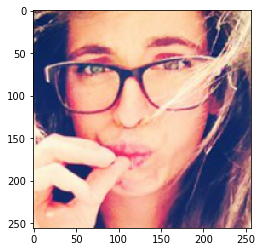

In [0]:
%matplotlib inline
img = Image.open('/content/drive/My Drive/testA/female_10328.jpg')
#print(np.array(img))
t_img = transform(img)
print(t_img.numpy().shape)
output = (((np.transpose(torch.squeeze(t_img.cpu()).numpy(), (1, 2, 0)) + 1)/2)*255).astype(np.uint8)
t_img = Image.fromarray(output)
plt.imshow(t_img)

In [22]:
model = UGATIT(in_channels=3, img_size=256, num_enc_blocks=3, num_enc_res_blocks=4, num_dec_upsample_blocks=2,
               num_dec_res_blocks=4, norm_type="instance", pad_type="reflection",
               local_discr_num_downsample=3, global_discr_num_downsample=5).cuda()

optimizer_G = optim.Adam(list(model.G_AB.parameters()) + list(model.G_BA.parameters()), lr=0.0001, betas=(0.5, 0.999))
optimizer_D = optim.Adam(list(model.D_AG.parameters()) + list(model.D_AL.parameters()) + list(model.D_BG.parameters()) + \
                             list(model.D_BL.parameters()), lr=0.0001, betas=(0.5, 0.999))

model.cuda();
model.train();
model.apply(init_weights_normal);
model.load_state_dict(torch.load('/content/drive/My Drive/40_UGATIT_new_big_FC_dataset.pth'))

#model, [optimizer_G, optimizer_D] = amp.initialize(model, [optimizer_G, optimizer_D], opt_level='O1', num_losses=2)
#model.load_state_dict(torch.load('/home/mpakhomov/Cycle_gan_pytorch/UGATIT_new_discr.pth'))

<All keys matched successfully>

In [0]:
def train_loop(num_epochs, train_dataloader, val_dataloader, model, optimizer_D, optimizer_G):
    liveloss = PlotLosses()
    lr = 0.0001
    max_norm = 1.0
    for epoch in range(num_epochs):
        logs = {}

        if epoch % 20 == 19:
            torch.save(model.state_dict(), '/content/drive/My Drive/'+ str(epoch + 1) + "_UGATIT_new_big_FC_dataset.pth")
            
        if epoch > 100:
            for param_group in optimizer_G.param_groups:
                param_group['lr'] = max(lr - 0.00001, 0)
                lr = max(lr - 0.00001, 0)
            for param_group in optimizer_D.param_groups:
                param_group['lr'] = max(lr - 0.00001, 0)
                lr = max(lr - 0.00001, 0)
                
        for idx, data in enumerate(train_dataloader):
            domain_A, domain_B = data["A"].cuda(), data["B"].cuda()
            
            #fake_B, cycle_BA, fake_A, cycle_AB = calc_Gs_outputs(G1, G2, domain_A, domain_B)
            fake_A, fake_B = model.forward(domain_A, domain_B)
            #print(fake_A)
            
            #set_requires_grad([model.D_AG, model.D_AL, model.D_BG, model.D_BL], False)
            optimizer_G.zero_grad()
            loss_G = model.backward_Gs(domain_A, domain_B)
            #with amp.scale_loss(loss_G, optimizer_G, loss_id=0) as scaled_loss:
                #scaled_loss.backward()
                #print(scaled_loss)
            
            #torch.nn.utils.clip_grad_norm_(amp.master_params(optimizer_G), max_norm)
            
            optimizer_G.step()
            
            #loss_g.append(loss_G.detach().item())
            logs["losses"] = loss_G.detach().item()
            
            model.G_AB.apply(model.rho_clipper)
            model.G_BA.apply(model.rho_clipper)
            
            #if idx % 5 == 4:
            #set_requires_grad([model.D_AG, model.D_AL, model.D_BG, model.D_BL], True)
            optimizer_D.zero_grad()
            loss_D = model.backward_Ds(domain_A, domain_B)
            #with amp.scale_loss(loss_D, optimizer_D, loss_id=1) as scaled_loss:
                #scaled_loss.backward()
                #print(scaled_loss)
                
            #torch.nn.utils.clip_grad_norm_(amp.master_params(optimizer_D), max_norm)
            
            
            optimizer_D.step()
            
            #loss_d.append(loss_D.detach().item())
            logs["val_losses"] = loss_D.detach().item()
            
            if idx % 200 == 199:
                print("Epoch: ", epoch + 1, "\n", "Gen loss: ", loss_G, "\n", "Discr loss: ", loss_D)
                #print("Epoch: ", epoch + 1, "\n", "Gen loss scaled: ", loss_G[-1], "\n", "Discr loss scaled: ", loss_d[-1])

            if idx % 1000 == 999:
                with torch.no_grad():
                    #real_pics[0].imshow(tensor_to_image(torch.squeeze(data["A"])))
                    #real_pic.imshow(np.transpose(torch.squeeze(domain_A).cpu().detach().numpy(), (1, 2, 0)))
                    #real_pics[0].relim()
                    #real_pics[0].autoscale_view()
                    #real_pics[0].figure.canvas.draw()
                    model.G_AB.eval()
                    output, _ = model.G_AB(domain_A)
                    output = (((np.transpose(torch.squeeze(output.detach().cpu()).numpy(), (1, 2, 0)) + 1)/2)*255).astype(np.uint8)
                    #output = torch.squeeze(output.cpu()))
                    save_image(output, "/content/drive/My Drive/people2anime_img_train_big_FC_epoch_{}_step_{}.jpg".format(str(epoch + 1), str(idx)))
                    #gen_pics[0].imshow(output)
                    #gen_pics[0].relim()
                    #gen_pics[0].autoscale_view()
                    #gen_pics[0].figure.canvas.draw()
                    #model.G_AB.train()
                    
                    #loss_axis[0].lines[0].set_xdata(list(range(len(loss_d))))
                    #loss_axis[0].lines[0].set_ydata(loss_d)
                    #loss_axis[0].lines[1].set_xdata(list(range(len(loss_g))))
                    #loss_axis[0].lines[1].set_ydata(loss_g)
                    #loss_axis[0].relim()
                    #loss_axis[0].autoscale_view()
                    #loss_axis[0].figure.canvas.draw()
                    print()
            if idx % 1000 == 999:
                for data in val_dataloader:
                    with torch.no_grad():
                        domain_A = data["A"].cuda()
                        #real_pics[1].imshow(tensor_to_image(torch.squeeze(data["A"])))
                        #real_pic.imshow(np.transpose(torch.squeeze(domain_A).cpu().detach().numpy(), (1, 2, 0)))
                        #real_pics[1].relim()
                        #real_pics[1].autoscale_view()
                        #real_pics[1].figure.canvas.draw()
                        model.G_AB.eval()
                        fake_B, _ = model.G_AB(domain_A)
                        output = (((np.transpose(torch.squeeze(fake_B.detach().cpu()).numpy(), (1, 2, 0)) + 1)/2)*255).astype(np.uint8)
                        save_image(output, "/content/drive/My Drive/people2anime_img_val_big_FC_epoch_{}_step_{}.jpg".format(str(epoch + 1), str(idx)))
                        #output = transforms.ToPILImage()(torch.squeeze(fake_B.cpu())).convert("RGB")
                        #gen_pics[1].imshow(output)
                        #gen_pics[1].relim()
                        #gen_pics[1].autoscale_view()
                        #gen_pics[1].figure.canvas.draw()
                        #model.G_AB.train()
                    break

        liveloss.update(logs)
        liveloss.draw()  

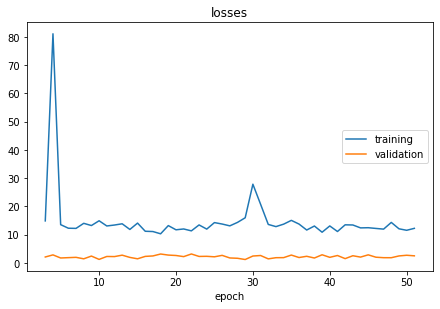

losses:
training   (min:   10.297, max:   81.093, cur:   12.229)
validation (min:    1.195, max:    3.155, cur:    2.499)
Epoch:  52 
 Gen loss:  tensor(12.5004, device='cuda:0', grad_fn=<AddBackward0>) 
 Discr loss:  tensor(2.0993, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  52 
 Gen loss:  tensor(12.8487, device='cuda:0', grad_fn=<AddBackward0>) 
 Discr loss:  tensor(2.6191, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  52 
 Gen loss:  tensor(23.2088, device='cuda:0', grad_fn=<AddBackward0>) 
 Discr loss:  tensor(1.6999, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  52 
 Gen loss:  tensor(12.9003, device='cuda:0', grad_fn=<AddBackward0>) 
 Discr loss:  tensor(2.0339, device='cuda:0', grad_fn=<AddBackward0>)
Epoch:  52 
 Gen loss:  tensor(11.2735, device='cuda:0', grad_fn=<AddBackward0>) 
 Discr loss:  tensor(2.2975, device='cuda:0', grad_fn=<AddBackward0>)

Epoch:  52 
 Gen loss:  tensor(12.8488, device='cuda:0', grad_fn=<AddBackward0>) 
 Discr loss:  tensor(1.7258, device

In [0]:
train_loop(200, train_dataloader, val_dataloader, model, optimizer_D, optimizer_G)

In [0]:
torch.save(model.state_dict(), "/home/mpakhomov/Cycle_gan_pytorch/UGATIT_best_res_with_apexfp32.pth")

In [0]:
for data in val_dataloader:
    inputs = data["A"].cuda()
    
    real_pics[0].imshow(tensor_to_image(torch.squeeze(data["A"])))
    real_pics[0].relim()
    real_pics[0].autoscale_view()
    real_pics[0].figure.canvas.draw()
    
    model.G_AB.eval()
    out, _ = model.G_AB(inputs)
    output, _ = model.G_AB(out)
    
    output = (((np.transpose(torch.squeeze(output.detach().cpu()).numpy(), (1, 2, 0)) + 1)/2)*255).astype(np.uint8)
    
    gen_pics[0].imshow(output)
    gen_pics[0].relim()
    gen_pics[0].autoscale_view()
    gen_pics[0].figure.canvas.draw()
    break

    